In [43]:
# 데이터 불러오기
import pandas as pd
ratings = pd.read_csv('./Data/ml-latest-small/ratings.csv')
movies = pd.read_csv('./Data/ml-latest-small/movies.csv')

In [44]:
# 피벗 테이블
rp = ratings.pivot_table(columns = ['movieId'], index = ['userId'], values = 'rating')

In [45]:
# 결측치 제거
rp = rp.fillna(0)

In [46]:
# 데이터 확인
rp

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Original Sparse Matrix(희소행렬)
A = rp.values
print('\n Shape of Original Sparse Matrix', A.shape)


 Shape of Original Sparse Matrix (610, 9724)


- 행렬 W는 원시 평가 점수 행렬과 동일한 차원
- 값은 0과 1만 가짐
- 사용자가 영화를 평가하면 1, 평가하지 않았으면 0
- 이런형태의 행렬은 오류 계산에 필요

In [48]:
# 최소 점수가 0.5점이므로 0.5점 이상이면 평가를 한 것
import numpy as np
W = A >= 0.5
W[W == True] = 1
W[W == False] = 0
W = W.astype(np.float64, copy = False)

- 유사하게 추천을 하기 위한 또다른 행렬 W_pred 필요
- W_pred도 0 또는 1의 값을 가진다
- W와 정반대의 값을 가진다
- 예측 평가 점수 행렬과 W_pred 행렬을 곱해 이미 평가가 제공된 모든 값을 0으로 만들기 위함
- 다른 평가나 리뷰가 되지 않은 값들도 내림차순으로 정렬했을 때 쉽게 상위로 올라가도록 함
- 사용자에게 그들이 평가나 리뷰하지 않은 영화 중 상위 5개나 10개 영화를 추천해줄 수 있게 된다

In [49]:
W_pred = A < 0.5 # W와 정반대의 값
W_pred[W == True] = 1
W_pred[W == False] = 0
W_pred = W_pred.astype(np.float64, copy = False)
np.fill_diagonal(W_pred, val = 0)

In [50]:
# 매개변수 설정
m, n = A.shape
n_iterations = 200
n_factors = 100
lmbda = 0.1 

In [51]:
# X, Y 생성 A = X x Y
X = 5*np.random.rand(m,n_factors)
Y = 5*np.random.rand(n_factors,n)

In [52]:
# shape 확인
X.shape, Y.shape

((610, 100), (100, 9724))

In [33]:
def get_error(A, X, Y, W):
    return np.sqrt(np.sum(W*(A - np.dot(X,Y)))**2)/np.sum(W)

- Y 값을 이용해 X를 최적화
- X 값을 이용해 Y를 최적화
- 이 과정을 반복횟수만큼 되풀이

In [53]:
errors = list()
for itr in range(n_iterations):
    X = np.linalg.solve(np.dot(Y,Y.T) + lmbda * np.eye(n_factors), np.dot(Y,A.T)).T
    Y = np.linalg.solve(np.dot(X.T, X) + lmbda * np.eye(n_factors), np.dot(X.T, A))
    if itr%10 == 0:
        print(itr, 'iterations completed', "RMSError value is :", get_error(A,X,Y,W))
    errors.append(get_error(A,X,Y,W))

0 iterations completed RMSError value is : 2.977773988759555
10 iterations completed RMSError value is : 1.0333266366583083
20 iterations completed RMSError value is : 1.002865095570066
30 iterations completed RMSError value is : 0.9906816254232578
40 iterations completed RMSError value is : 0.9840259015638279
50 iterations completed RMSError value is : 0.9797948173774491
60 iterations completed RMSError value is : 0.9768500337148024
70 iterations completed RMSError value is : 0.9746750604129687
80 iterations completed RMSError value is : 0.9729998375295619
90 iterations completed RMSError value is : 0.9716685205168014
100 iterations completed RMSError value is : 0.970584511178857
110 iterations completed RMSError value is : 0.9696845969535888
120 iterations completed RMSError value is : 0.9689256013396688
130 iterations completed RMSError value is : 0.9682769855371817
140 iterations completed RMSError value is : 0.9677165123198364
150 iterations completed RMSError value is : 0.9672275

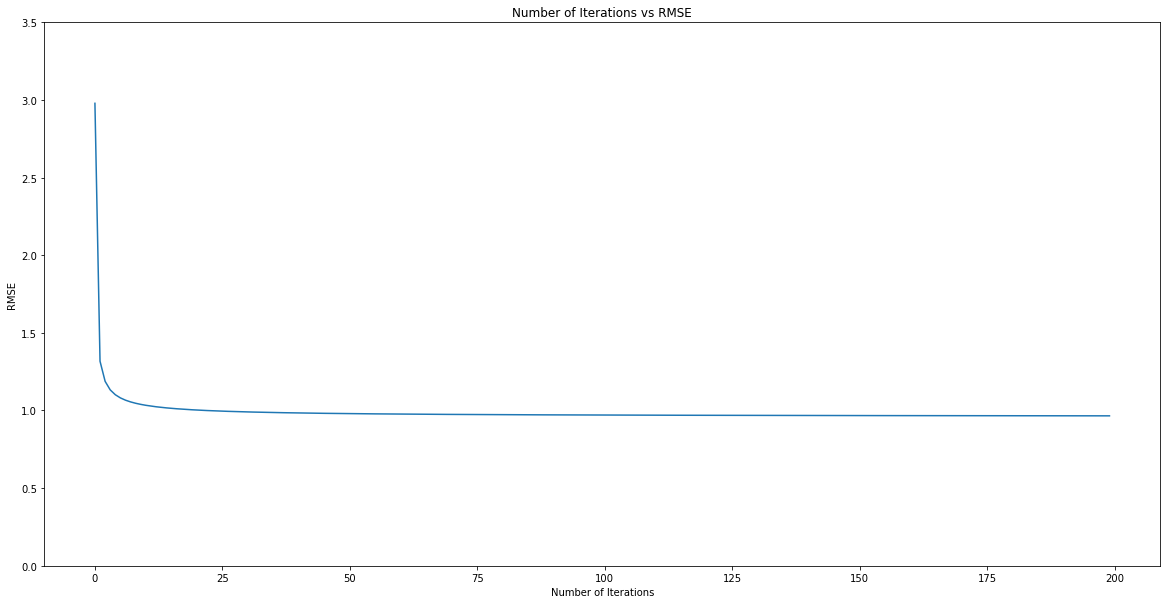

In [54]:
# errors 시각화
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
plt.plot(errors)
plt.ylim([0, 3.5])
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('Number of Iterations vs RMSE')
plt.show()

In [94]:
A_hat = np.dot(X,Y)

In [117]:
# A_hat을 이용해 영화를 사용자에게 추천
def print_recommovies(uid = 315, n_movies = 15, pred_mat = A_hat, wpred_mat = W_pred):
    pred_recos = pred_mat * wpred_mat
    pd_predrecos = pd.DataFrame(pred_recos, index = rp.index, columns = rp.columns)
    pred_ratings = pd_predrecos.loc[uid,:].sort_values(ascending = False).to_frame()
    pred_topratings = pred_ratings[:n_movies]
    pred_topratings.columns = ['pred_ratings']
    pred_topratings = pd.DataFrame(pred_topratings)
    pred_topratings['index1'] = pred_topratings.index
    pred_topratings['index1'] = pred_topratings['index1'].astype('int64')
    pred_topratings = pd.merge(pred_topratings, movies[['movieId', 'title']], left_on = 'index1', right_on = 'movieId')
    del pred_topratings['index1']
    return pred_topratings

In [125]:
predmtrx = print_recommovies(uid = 355, n_movies = 10, pred_mat = A_hat, wpred_mat = W_pred)

In [126]:
predmtrx

,pred_ratings,movieId,title
0,1.298834,1580,Men in Black (a.k.a. MIB) (1997)
1,1.225308,1198,Raiders of the Lost Ark (Indiana Jones and the...
2,0.985525,2628,Star Wars: Episode I - The Phantom Menace (1999)
3,0.932823,480,Jurassic Park (1993)
4,0.914534,1721,Titanic (1997)
5,0.826331,3175,Galaxy Quest (1999)
6,0.808574,316,Stargate (1994)
7,0.619444,2916,Total Recall (1990)
8,0.590581,910,Some Like It Hot (1959)
9,0.506446,915,Sabrina (1954)


#### 협업 필터링에서의 그리드 검색

In [127]:
# 매개변수 설정
niters = [20,50,100,200]
factors = [30,50,70,100]
lambdas = [0.001,0.01,0.05,0.1]

In [128]:
init_error = float('inf')

In [132]:
print('\n\n Grid Search results of ALS Matrix Factorization:\n')
for niter in niters:
    for facts in factors:
        for lmbd in lambdas:
            X = 5*np.random.rand(m,facts)
            Y = 5*np.random.rand(facts,n)
            for itr in range(niter):
                X = np.linalg.solve(np.dot(Y,Y.T) + lmbd*np.eye(facts), np.dot(Y, A.T)).T
                Y = np.linalg.solve(np.dot(X.T, X) + lmbd*np.eye(facts), np.dot(X.T, A))
            error = get_error(A,X,Y,W)
            if error < init_error:
                print("Number of iters", niter, "Number of Factors", facts, "Lambda", lmbd, "RMSE", error)
                init_error = error



 Grid Search results of ALS Matrix Factorization:

Number of iters 20 Number of Factors 30 Lambda 0.001 RMSE 1.7176980704424953
Number of iters 20 Number of Factors 50 Lambda 0.001 RMSE 1.4499277031104034
Number of iters 20 Number of Factors 70 Lambda 0.001 RMSE 1.2437123170036621
Number of iters 20 Number of Factors 100 Lambda 0.001 RMSE 0.9998832085168377
Number of iters 50 Number of Factors 100 Lambda 0.001 RMSE 0.9790195262636755
Number of iters 100 Number of Factors 100 Lambda 0.001 RMSE 0.9698919070950641
Number of iters 200 Number of Factors 100 Lambda 0.001 RMSE 0.9649779034422031
